In [89]:
!pip install conllu
!pip install torchtext

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
import conllu
from torchtext.vocab import GloVe
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
# from torchtext.vocab import build_vocab_from_iterator, Vocab
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

torch.manual_seed(42)

In [91]:
##------------------ Global Variable -----------------------------------------------------
p = 3
s = 2
start_tag = '<S>'
end_tag = '</S>'
unknown_token = '<UKN>'
padding_token = '<PAD>'
BATCH_SIZE = 64
round_precision = 5
EPOCHS = 10
embedding_dim = 100
HIDDEN_LAYER_DIMENSION = 200

glove_file_path = '/content/glove.6B.100d.txt'

unknown_word_embedding = np.zeros(embedding_dim)
start_tag_embedding = np.round(np.random.normal(size=(embedding_dim,)) , round_precision)
end_tag_embedding = np.round(np.random.normal(size=(embedding_dim)) , round_precision)

In [92]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [93]:
file = open('/content/en_atis-ud-train.conllu' , 'r')
train_data = file.read()
file.close()

file = open('/content/en_atis-ud-dev.conllu', 'r')
val_data = file.read()
file.close()

file = open('/content/en_atis-ud-test.conllu', 'r')
test_data = file.read()
file.close()

In [94]:
train_data

"# sent_id = 0001.train\n# text = what is the cost of a round trip flight from pittsburgh to atlanta beginning on april twenty fifth and returning on may sixth\n1\twhat\twhat\tPRON\t_\tPronType=Int,Rel\t0\troot\t_\t_\n2\tis\tbe\tAUX\t_\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin\t1\tcop\t_\t_\n3\tthe\tthe\tDET\t_\tPronType=Art\t4\tdet\t_\t_\n4\tcost\tcost\tNOUN\t_\tNumber=Sing\t1\tnsubj\t_\t_\n5\tof\tof\tADP\t_\t_\t7\tcase\t_\t_\n6\ta\ta\tDET\t_\tPronType=Art\t7\tdet\t_\t_\n7\tround\tround\tNOUN\t_\tNumber=Sing\t4\tnmod\t_\t_\n8\ttrip\ttrip\tNOUN\t_\tNumber=Sing\t7\tcompound\t_\t_\n9\tflight\tflight\tNOUN\t_\tNumber=Sing\t7\tnmod\t_\t_\n10\tfrom\tfrom\tADP\t_\t_\t11\tcase\t_\t_\n11\tpittsburgh\tPittsburgh\tPROPN\t_\tNumber=Sing\t9\tnmod\t_\t_\n12\tto\tto\tADP\t_\t_\t13\tcase\t_\t_\n13\tatlanta\tAtlanta\tPROPN\t_\tNumber=Sing\t9\tnmod\t_\t_\n14\tbeginning\tbegin\tVERB\t_\tTense=Pres|VerbForm=Part\t9\tnmod\t_\t_\n15\ton\ton\tADP\t_\t_\t16\tcase\t_\t_\n16\tapril\tApril\tNOUN\t_

In [95]:
def preprocssing(data):

  sentences = []   # return structure

  currrent_sentence = []
  sentence_token = []
  token_pos = []


  lines = data.strip().split('\n')

  for line in lines:

    if(len(line) < 1):
      currrent_sentence.append(sentence_token)
      currrent_sentence.append(token_pos)
      sentences.append(currrent_sentence)

      sentence_token = []
      token_pos = []
      currrent_sentence = []

    elif line.startswith('# sent_id'):
      continue

    elif line.startswith('# text ='):
      continue

    else:
      tokens =line.split('\t')
      sentence_token.append(tokens[1])
      token_pos.append(tokens[3])

  currrent_sentence.append(sentence_token)
  currrent_sentence.append(token_pos)
  sentences.append(currrent_sentence)
  return sentences

In [96]:
def get_datastructres(sentence_pos,p,s):

  word_freq = dict()
  pos_tags = set()

  processed_dataset = []
  start_tag_list = []
  end_tag_list = []

  for i in range(p):
    start_tag_list.append(start_tag)

  for i in range(s):
    end_tag_list.append(end_tag)

  for temp in sentence_pos:

    sentence_token = temp[0]
    pos_list = temp[1]

    for pos in pos_list:
      pos_tags.add(pos)

    sentence_length = len(sentence_token)
    new_sentence = start_tag_list + sentence_token + end_tag_list

    for index in range(p, sentence_length+p):

      if new_sentence[index] in word_freq:
        word_freq[new_sentence[index]] +=1

      else:
        word_freq[new_sentence[index]] = 1


      single_entry = []
      p_1_s_token = new_sentence[index-p : index+s+1]

      single_entry.append(p_1_s_token)
      single_entry.append(pos_list[index-p])
      processed_dataset.append(single_entry)

  return pos_tags , word_freq , processed_dataset


In [97]:
def generate_vocab(word_freq):

  vocab = set()

  for key, value in word_freq.items():
    if value >= 3:
      vocab.add(key)

  new_word_freq = dict()

  for word in vocab:
    new_word_freq[word] = word_freq[word]

  # print(vocab)
  return vocab, new_word_freq


In [98]:
def load_glove_embeddings(file_path):
    word_embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        next(f)  # Skip the first line

        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            word_embeddings[word] = vector
    return word_embeddings

In [99]:
def get_embbed_train_dataset(dataset):

  sentence_pos = preprocssing(dataset)
  pos_tags , word_freq , processed_dataset = get_datastructres(sentence_pos,p,s)
  vocab, word_freq = generate_vocab(word_freq)

  pos_tag_list = list(pos_tags)
  encoder = OneHotEncoder(sparse=False)
  pos_tag_embedings_one_hot = encoder.fit_transform(np.array(pos_tag_list).reshape(-1, 1))

  pos_tag_embedding = dict()

  for category, one_hot_vector in zip(pos_tag_list, pos_tag_embedings_one_hot):
      pos_tag_embedding[category] = one_hot_vector


  glove_embeddings = load_glove_embeddings(glove_file_path)

  embedded_dataset = []

  for entry in processed_dataset:

    token_list = entry[0]
    tag = entry[1]

    data_entry = []
    token_embedding = []

    for token in token_list :

        if token == start_tag:
          token_embedding.append(start_tag_embedding)

        elif token == end_tag:
          token_embedding.append(end_tag_embedding)

        elif token not in glove_embeddings:
          token_embedding.append(unknown_word_embedding)

        else:
          token_embedding.append(np.array(glove_embeddings[token]))

    data_entry.append(token_embedding)
    data_entry.append(pos_tag_embedding[tag])
    embedded_dataset.append(data_entry)

  return vocab , word_freq, pos_tag_list, pos_tag_embedding, embedded_dataset, glove_embeddings

In [100]:
def get_embbed_val_dataset(dataset, vocab , pos_tags , pos_tag_embedding, global_embedding):

  sentence_pos = preprocssing(dataset)
  _ , word_freq , processed_dataset = get_datastructres(sentence_pos,p,s)
  _, word_freq = generate_vocab(word_freq)


  embedded_dataset = []

  for entry in processed_dataset:

    token_list = entry[0]
    tag = entry[1]

    data_entry = []
    token_embedding = []

    for token in token_list :

        if token == start_tag:
          token_embedding.append(start_tag_embedding)

        elif token == end_tag:
          token_embedding.append(end_tag_embedding)

        elif token not in global_embedding:
          token_embedding.append(unknown_word_embedding)

        else:
          token_embedding.append(np.array(global_embedding[token]))

    data_entry.append(token_embedding)

    if tag in pos_tag_embedding:
      data_entry.append(pos_tag_embedding[tag])

    else:
      data_entry.append(np.zeros(len(pos_tags)))

    embedded_dataset.append(data_entry)

  return word_freq, embedded_dataset

In [101]:
vocab, train_word_freq , pos_tags , pos_tag_embedding , train_embedded_dataset, global_embedding = get_embbed_train_dataset(train_data)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [102]:
train_embedded_dataset[0]

[[array([ 0.00369,  0.09831,  1.46462, -0.42127,  1.67434,  1.80923,
         -1.07051, -1.42354, -0.41211, -0.48648, -0.52596, -0.07858,
          0.25852, -1.38451,  0.88653, -0.72078,  0.77786, -0.96192,
         -0.15295,  0.84908,  0.03686,  0.61918, -0.05521,  0.29401,
          1.21668, -2.10816, -0.6949 ,  0.17463,  0.4124 , -0.74239,
         -0.45498, -0.82165, -1.48102,  0.31342,  0.43765, -0.55181,
          1.55527, -1.56373,  1.16338,  1.32137, -0.58392, -1.22604,
          0.50444, -0.72986,  1.18717, -0.09488, -0.11936, -0.02458,
          0.40536, -0.00564,  0.54892,  1.18061,  0.59097, -0.77144,
          0.27114, -0.53901, -1.82739, -0.34503, -0.24611,  2.01972,
         -0.66738,  0.52259,  1.58815, -1.90938,  0.36141, -0.09612,
         -2.87921, -1.14431,  1.06416, -1.27227, -0.16557, -1.48932,
         -1.02805, -0.17838,  0.0055 , -1.15766, -1.42754,  0.13322,
         -0.32467,  0.88389, -1.60342, -1.66065, -0.0207 , -0.60919,
          1.20198,  0.25443,  0.08

In [103]:
# sentence_pos = preprocssing(train_data)
# sentence_pos[0]

In [104]:
# pos_tags , word_freq , processed_dataset = get_datastructres(sentence_pos,p,s)

In [105]:
# processed_dataset

In [106]:
train_embedded_dataset[0]

[[array([ 0.00369,  0.09831,  1.46462, -0.42127,  1.67434,  1.80923,
         -1.07051, -1.42354, -0.41211, -0.48648, -0.52596, -0.07858,
          0.25852, -1.38451,  0.88653, -0.72078,  0.77786, -0.96192,
         -0.15295,  0.84908,  0.03686,  0.61918, -0.05521,  0.29401,
          1.21668, -2.10816, -0.6949 ,  0.17463,  0.4124 , -0.74239,
         -0.45498, -0.82165, -1.48102,  0.31342,  0.43765, -0.55181,
          1.55527, -1.56373,  1.16338,  1.32137, -0.58392, -1.22604,
          0.50444, -0.72986,  1.18717, -0.09488, -0.11936, -0.02458,
          0.40536, -0.00564,  0.54892,  1.18061,  0.59097, -0.77144,
          0.27114, -0.53901, -1.82739, -0.34503, -0.24611,  2.01972,
         -0.66738,  0.52259,  1.58815, -1.90938,  0.36141, -0.09612,
         -2.87921, -1.14431,  1.06416, -1.27227, -0.16557, -1.48932,
         -1.02805, -0.17838,  0.0055 , -1.15766, -1.42754,  0.13322,
         -0.32467,  0.88389, -1.60342, -1.66065, -0.0207 , -0.60919,
          1.20198,  0.25443,  0.08

In [107]:
pos_tags

['INTJ',
 'ADP',
 'VERB',
 'ADJ',
 'ADV',
 'NOUN',
 'NUM',
 'AUX',
 'PRON',
 'DET',
 'CCONJ',
 'PROPN',
 'PART']

In [108]:
# pos_tag_list = list(pos_tags)
# encoder = OneHotEncoder(sparse=False)
# one_hot_encoding = encoder.fit_transform(np.array(pos_tag_list).reshape(-1, 1))

In [109]:
pos_tag_embedding

{'INTJ': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'ADP': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'VERB': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 'ADJ': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'ADV': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'NOUN': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'NUM': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 'AUX': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'PRON': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'DET': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'CCONJ': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'PROPN': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 'PART': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])}

In [110]:
val_word_freq , val_embedded_dataset = get_embbed_val_dataset(val_data, vocab , pos_tags , pos_tag_embedding, global_embedding)
train_word_freq , test_embedded_dataset = get_embbed_val_dataset(test_data ,vocab , pos_tags , pos_tag_embedding, global_embedding)

In [111]:
val_embedded_dataset[0]

[[array([ 0.00369,  0.09831,  1.46462, -0.42127,  1.67434,  1.80923,
         -1.07051, -1.42354, -0.41211, -0.48648, -0.52596, -0.07858,
          0.25852, -1.38451,  0.88653, -0.72078,  0.77786, -0.96192,
         -0.15295,  0.84908,  0.03686,  0.61918, -0.05521,  0.29401,
          1.21668, -2.10816, -0.6949 ,  0.17463,  0.4124 , -0.74239,
         -0.45498, -0.82165, -1.48102,  0.31342,  0.43765, -0.55181,
          1.55527, -1.56373,  1.16338,  1.32137, -0.58392, -1.22604,
          0.50444, -0.72986,  1.18717, -0.09488, -0.11936, -0.02458,
          0.40536, -0.00564,  0.54892,  1.18061,  0.59097, -0.77144,
          0.27114, -0.53901, -1.82739, -0.34503, -0.24611,  2.01972,
         -0.66738,  0.52259,  1.58815, -1.90938,  0.36141, -0.09612,
         -2.87921, -1.14431,  1.06416, -1.27227, -0.16557, -1.48932,
         -1.02805, -0.17838,  0.0055 , -1.15766, -1.42754,  0.13322,
         -0.32467,  0.88389, -1.60342, -1.66065, -0.0207 , -0.60919,
          1.20198,  0.25443,  0.08

In [112]:
test_embedded_dataset[0]

[[array([ 0.00369,  0.09831,  1.46462, -0.42127,  1.67434,  1.80923,
         -1.07051, -1.42354, -0.41211, -0.48648, -0.52596, -0.07858,
          0.25852, -1.38451,  0.88653, -0.72078,  0.77786, -0.96192,
         -0.15295,  0.84908,  0.03686,  0.61918, -0.05521,  0.29401,
          1.21668, -2.10816, -0.6949 ,  0.17463,  0.4124 , -0.74239,
         -0.45498, -0.82165, -1.48102,  0.31342,  0.43765, -0.55181,
          1.55527, -1.56373,  1.16338,  1.32137, -0.58392, -1.22604,
          0.50444, -0.72986,  1.18717, -0.09488, -0.11936, -0.02458,
          0.40536, -0.00564,  0.54892,  1.18061,  0.59097, -0.77144,
          0.27114, -0.53901, -1.82739, -0.34503, -0.24611,  2.01972,
         -0.66738,  0.52259,  1.58815, -1.90938,  0.36141, -0.09612,
         -2.87921, -1.14431,  1.06416, -1.27227, -0.16557, -1.48932,
         -1.02805, -0.17838,  0.0055 , -1.15766, -1.42754,  0.13322,
         -0.32467,  0.88389, -1.60342, -1.66065, -0.0207 , -0.60919,
          1.20198,  0.25443,  0.08

## Dataset

In [113]:
class corpus_dataset(Dataset):

  def __init__(self , pos_tag_embedding , embbed_dataset , word_freq , vocab, global_embedding):

    super().__init__()

    self.pos_tag_embedding = pos_tag_embedding
    self.embbed_dataset = embbed_dataset
    self.word_freq = word_freq
    self.vocab = vocab
    self.global_embedding = global_embedding


  def __len__(self):
    return len(self.embbed_dataset)


  def __getitem__(self, index):
    # print(self.embbed_dataset[index])
    data_entry = self.embbed_dataset[index]
    flattern_array = np.array(data_entry[0]).reshape(-1)
    return torch.tensor(flattern_array) , torch.tensor(data_entry[1])


In [114]:
train_dataset = corpus_dataset(pos_tag_embedding, train_embedded_dataset, train_word_freq, vocab, global_embedding)

In [115]:
# new_dataset.__getitem__(0)

In [116]:
len(train_dataset)

48655

In [117]:
train_dataset.__getitem__(0)

(tensor([ 3.6900e-03,  9.8310e-02,  1.4646e+00, -4.2127e-01,  1.6743e+00,
          1.8092e+00, -1.0705e+00, -1.4235e+00, -4.1211e-01, -4.8648e-01,
         -5.2596e-01, -7.8580e-02,  2.5852e-01, -1.3845e+00,  8.8653e-01,
         -7.2078e-01,  7.7786e-01, -9.6192e-01, -1.5295e-01,  8.4908e-01,
          3.6860e-02,  6.1918e-01, -5.5210e-02,  2.9401e-01,  1.2167e+00,
         -2.1082e+00, -6.9490e-01,  1.7463e-01,  4.1240e-01, -7.4239e-01,
         -4.5498e-01, -8.2165e-01, -1.4810e+00,  3.1342e-01,  4.3765e-01,
         -5.5181e-01,  1.5553e+00, -1.5637e+00,  1.1634e+00,  1.3214e+00,
         -5.8392e-01, -1.2260e+00,  5.0444e-01, -7.2986e-01,  1.1872e+00,
         -9.4880e-02, -1.1936e-01, -2.4580e-02,  4.0536e-01, -5.6400e-03,
          5.4892e-01,  1.1806e+00,  5.9097e-01, -7.7144e-01,  2.7114e-01,
         -5.3901e-01, -1.8274e+00, -3.4503e-01, -2.4611e-01,  2.0197e+00,
         -6.6738e-01,  5.2259e-01,  1.5881e+00, -1.9094e+00,  3.6141e-01,
         -9.6120e-02, -2.8792e+00, -1.

In [118]:
val_dataset = corpus_dataset(pos_tag_embedding, val_embedded_dataset, val_word_freq, vocab, global_embedding)

In [119]:
# val_dataset[2]

In [120]:
test_dataset = corpus_dataset(pos_tag_embedding, test_embedded_dataset, val_word_freq, vocab, global_embedding)
# test_dataset[0]

In [121]:
print(f'Length of train Dataset :- {len(train_dataset)}')
print(f'Length of validation Dataset :- {len(val_dataset)}')
print(f'Length of test Dataset :- {len(test_dataset)}')

Length of train Dataset :- 48655
Length of validation Dataset :- 6644
Length of test Dataset :- 6580


In [122]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


# for i in train_dataloader:
#   print(i, i[0].shape)
#   break

print(f'Length of train Loader :- {len(train_dataloader)}')
print(f'Length of validation Loader :- {len(val_dataloader)}')
print(f'Length of validation Loader :- {len(test_dataloader)}')


Length of train Loader :- 761
Length of validation Loader :- 104
Length of validation Loader :- 103


## Neural Network

In [123]:
class ffnn_model(nn.Module):

    def __init__(self, input_dim , hidden_dim, output_dim):
        super(ffnn_model, self).__init__()

        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, 2*hidden_dim)
        self.l3 = nn.Linear(2*hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)


    def forward(self, x):
        x = x.to(self.l1.weight.dtype)
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

In [196]:
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_count = 0
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives
    tn = 0  # True negatives

    predicated =[]
    original =[]

    with torch.no_grad():
        for words_tensor, tag_tensor in data_loader:
            words_tensor, tag_tensor = words_tensor.to(device), tag_tensor.to(device)
            output = model(words_tensor)
            loss = criterion(output, tag_tensor)
            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total_correct += (predicted == torch.argmax(tag_tensor, dim=1)).sum().item()

            for pred, true in zip(predicted, tag_tensor):

                pred_pos = pred.item()
                true_pos = true.nonzero().squeeze().tolist()

                if isinstance(true_pos, int):
                    predicated.append(pred_pos)
                    original.append(true_pos)

                if pred_pos == 1 and true_pos:
                    tp += 1
                elif pred_pos == 1 and not true_pos:
                    fp += 1
                elif pred_pos == 0 and true_pos:
                    fn += 1
                else:
                    tn += 1

            total_count += tag_tensor.size(0)

    loss = total_loss / len(data_loader)
    accuracy = total_correct / total_count

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return loss, accuracy,precision , recall,  f1 ,confusion_matrix(np.array(original) , np.array(predicated))




In [197]:
model = ffnn_model((p+s+1)*embedding_dim , HIDDEN_LAYER_DIMENSION , len(pos_tags)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [199]:
epcoh_list = [e for e in range(EPOCHS)]
val_acc_list = []
val_loss_list = []
train_acc_list = []
train_loss_list = []



for epoch in range(EPOCHS):
    for words_tensor, tag_tensor in train_dataloader:
        words_tensor, tag_tensor = words_tensor.to(device), tag_tensor.to(device)
        optimizer.zero_grad()
        output = model(words_tensor)
        loss = criterion(output, tag_tensor)
        loss.backward()
        optimizer.step()

    train_loss, train_accuracy, _, _ , _, _ = evaluate(model, train_dataloader, criterion)
    val_loss, val_accuracy, _, _, _, _  = evaluate(model, val_dataloader, criterion)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)

    print(f"Epoch {epoch+1},  TrainLoss: {train_loss:.4f} ,  Train acc: {train_accuracy:.4f}  ,  Validation Loss: {val_loss:.4f} , Validation Accuracy: {val_accuracy:.4f}")

Epoch 1,  TrainLoss: 0.0591 ,  Train acc: 0.9813  ,  Validation Loss: 0.0815 , Validation Accuracy: 0.9744
Epoch 2,  TrainLoss: 0.0562 ,  Train acc: 0.9811  ,  Validation Loss: 0.0896 , Validation Accuracy: 0.9725
Epoch 3,  TrainLoss: 0.0407 ,  Train acc: 0.9871  ,  Validation Loss: 0.0765 , Validation Accuracy: 0.9791
Epoch 4,  TrainLoss: 0.0422 ,  Train acc: 0.9853  ,  Validation Loss: 0.0905 , Validation Accuracy: 0.9744
Epoch 5,  TrainLoss: 0.0391 ,  Train acc: 0.9866  ,  Validation Loss: 0.0912 , Validation Accuracy: 0.9756
Epoch 6,  TrainLoss: 0.0388 ,  Train acc: 0.9878  ,  Validation Loss: 0.0849 , Validation Accuracy: 0.9791
Epoch 7,  TrainLoss: 0.0296 ,  Train acc: 0.9895  ,  Validation Loss: 0.0912 , Validation Accuracy: 0.9800
Epoch 8,  TrainLoss: 0.0298 ,  Train acc: 0.9897  ,  Validation Loss: 0.0862 , Validation Accuracy: 0.9794
Epoch 9,  TrainLoss: 0.0305 ,  Train acc: 0.9893  ,  Validation Loss: 0.0856 , Validation Accuracy: 0.9792
Epoch 10,  TrainLoss: 0.0293 ,  Train

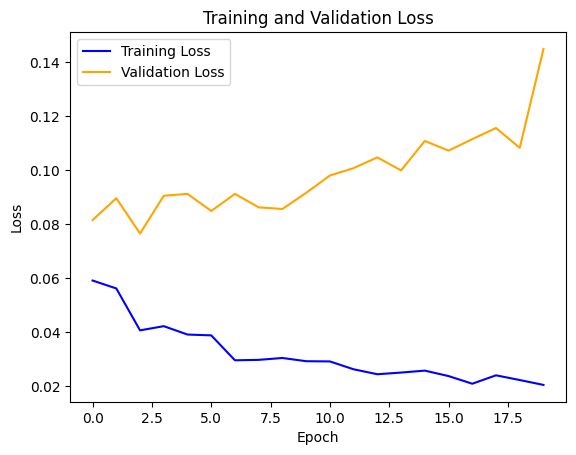

In [200]:
plt.plot(train_loss_list, label='Training Loss', color='blue')
plt.plot(val_loss_list, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

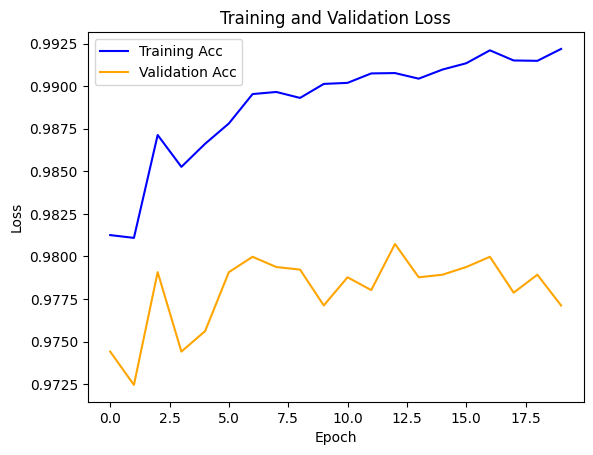

In [201]:
plt.plot(train_acc_list, label='Training Acc', color='blue')
plt.plot(val_acc_list, label='Validation Acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

=========================== Validation Data ===========================
Validation Loss:  0.1448
Validation Accuracy: 0.9771
Validation Precision: 0.9993
Validation Recall: 0.9882
Validation F1 Score: 0.9937


<Figure size 800x600 with 0 Axes>

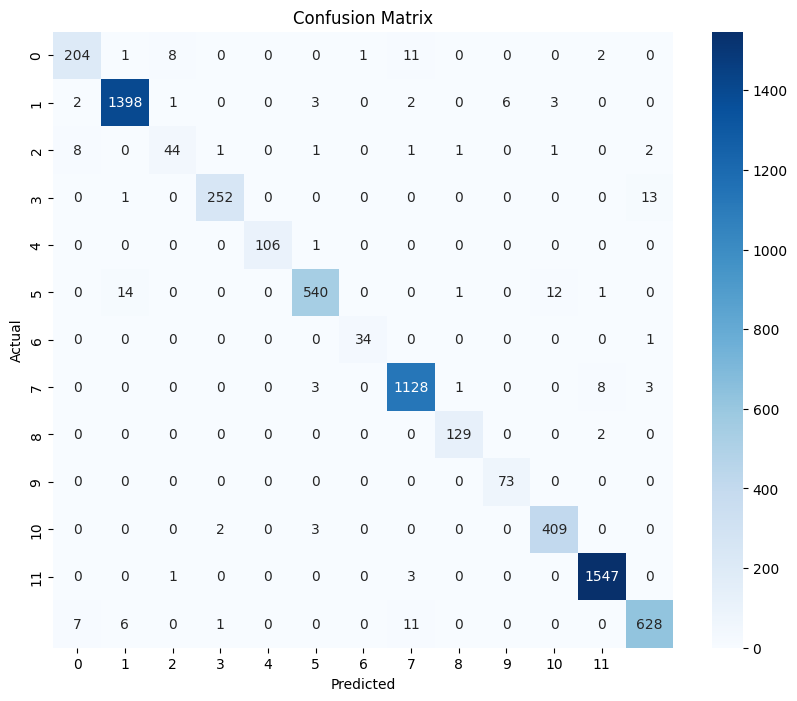

In [202]:
val_loss, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix = evaluate(model, val_dataloader, criterion)

print(f'=========================== Validation Data ===========================')
print(f'Validation Loss:  {val_loss:.4f}')
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print("=========================================================================")

plt.figure(figsize=(8, 6))
plt.figure(figsize=(10, 8))
sns.heatmap(val_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(12), yticklabels=np.arange(12))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

=========================== Test Data ===========================
Test Loss:  0.1043
Test Accuracy: 0.9824
Test Precision: 1.0000
Test Recall: 0.9815
Test F1 Score: 0.9907


<Figure size 800x600 with 0 Axes>

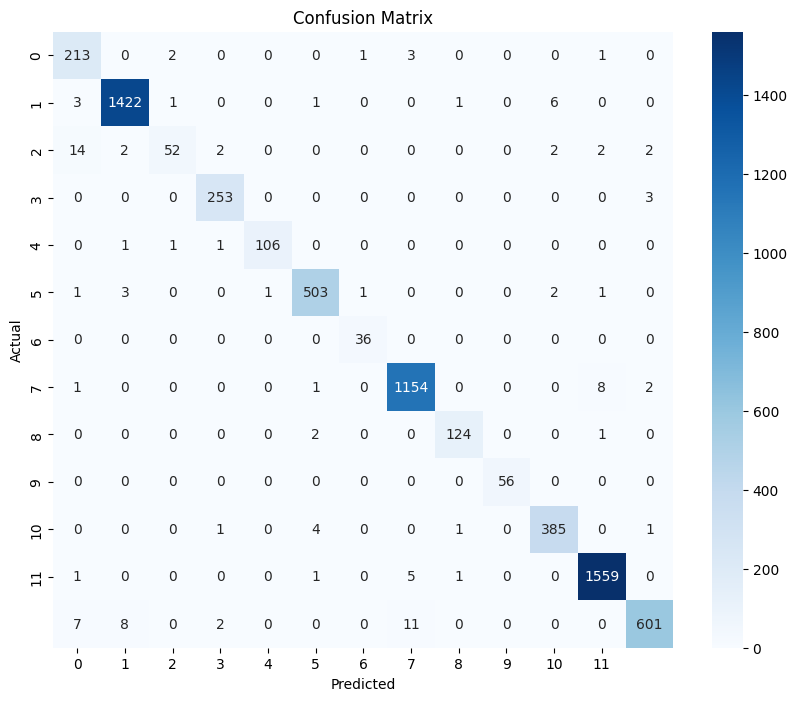

In [203]:
test_loss, test_accuracy, test_precision, test_recall, test_f1 , test_confusion_matrix = evaluate(model, test_dataloader, criterion)

print(f'=========================== Test Data ===========================')
print(f'Test Loss:  {test_loss:.4f}')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("=========================================================================")

plt.figure(figsize=(8, 6))
plt.figure(figsize=(10, 8))
sns.heatmap(test_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(12), yticklabels=np.arange(12))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [204]:
torch.save(model.state_dict(), 'ffnn_model.pt')
loaded_model  = ffnn_model((p+s+1)*embedding_dim , HIDDEN_LAYER_DIMENSION , len(pos_tags))
loaded_model.load_state_dict(torch.load('ffnn_model.pt'))
print(loaded_model)

ffnn_model(
  (l1): Linear(in_features=600, out_features=200, bias=True)
  (l2): Linear(in_features=200, out_features=400, bias=True)
  (l3): Linear(in_features=400, out_features=13, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.01)
)


In [205]:
start_tag_list = []
end_tag_list = []

for i in range(p):
  start_tag_list.append(start_tag)

for i in range(s):
  end_tag_list.append(end_tag)

try:
    while(1):
        sentence = input("Enter your sentence:   ")
        tokens = sentence.split(' ')
        punc = [',', '.', '!', '?']
        tokens = [word.lower() for word in tokens if word not in punc]
        sentence_length = len(tokens)

        new_sentence = start_tag_list + tokens + end_tag_list
        sentence_embedding = []

        for token in new_sentence :
          if token == start_tag:
            sentence_embedding.append(start_tag_embedding)

          elif token == end_tag:
            sentence_embedding.append(end_tag_embedding)

          elif token not in global_embedding:
            sentence_embedding.append(unknown_word_embedding)

          else:
            sentence_embedding.append(np.array(global_embedding[token]))

          single_entry = []
          # word_entry = []
          for index in range(p, sentence_length+p):

            p_1_s_token = sentence_embedding[index-p : index+s+1]

            # word_entry.append(new_sentence[index-p : index+s+1])
            single_entry.append(p_1_s_token)

        # print(word_entry)
        answer = []

        for entry in single_entry:

          flattern_array = torch.tensor(np.array(entry).flatten())
          # flattern_array = torch.tensor(np.array(entry).flatten()).long()
          output = loaded_model(flattern_array.to(device))
          _, predicted = torch.max(output, 0)

          for tag , embedding in pos_tag_embedding.items():

            if predicted == torch.argmax(torch.tensor(embedding), dim=0):
              answer.append(tag)
              break

        for i in range(sentence_length):
          print(tokens[i] , "   ->    ", answer[i])

except KeyboardInterrupt:
    print("")


## Obervation -3


- batch = 32
- hidden layer size = 400
-     - self.l1 = nn.Linear(input_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, 2*hidden_dim)
        self.l4 = nn.Linear(2*hidden_dim, 3*hidden_dim)
        self.l5 = nn.Linear(3*hidden_dim, 2*hidden_dim)
        self.l6 = nn.Linear(2*hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)


- p=s=2
- mebdding = 100

-20 epoc

- Test Loss:  0.1527
- Test Accuracy: 0.9789
- Test Precision: 1.0000
- Test Recall: 0.9909
- Test F1 Score: 0.9954



## Obervation -1


- batch = 32
- hidden layer size = 200
- hidden layer = 2
- p=s=2

-20 epoc

-Test Loss:  0.1085
-Test Accuracy: 0.9824
-Precision: 1.0000
-Recall: 0.9876
- F1 Score: 0.9937

=========================== Validation Data ===========================
- Validation Loss:  0.1262
- Validation Accuracy: 0.9770
- Precision: 0.9993
- Recall: 0.9923
- F1 Score: 0.9958



## Obervation -2


- batch = 32
- hidden layer size = 400
-     - self.l1 = nn.Linear(input_dim, hidden_dim)
    -    self.l2 = nn.Linear(hidden_dim, hidden_dim)
  -      self.l3 = nn.Linear(hidden_dim, 2*hidden_dim)
  -      self.l4 = nn.Linear(2*hidden_dim, 3*hidden_dim)
    -    self.l5 = nn.Linear(3*hidden_dim, 2*hidden_dim)
    -    self.l6 = nn.Linear(2*hidden_dim, hidden_dim)
   -     self.l7 = nn.Linear(hidden_dim, hidden_dim)
     -   self.l8 = nn.Linear(hidden_dim, output_dim)
      -  self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

- p=s=2
- mebdding = 100

-20 epoc

- Test Loss:  0.1527
- Test Accuracy: 0.9789
- Test Precision: 1.0000
- Test Recall: 0.9909
- Test F1 Score: 0.9954

=========================== Validation Data ===========================
- Validation Loss:  0.1874
- Validation Accuracy: 0.9750
- Validation Precision: 1.0000
- Validation Recall: 0.9936
- Validation F1 Score: 0.9968


==============================================================================================

epoch = 30
p=s=3

- Test Loss:  0.1299
- Test Accuracy: 0.9780
- Test Precision: 1.0000
- Test Recall: 0.9811
- Test F1 Score: 0.9905


- Validation Loss:  0.1187
- Validation Accuracy: 0.9783
- Validation Precision: 1.0000
- Validation Recall: 0.9908
- Validation F1 Score: 0.9954
